# Visualizing Features with PCA

One common application for PCA is to visualize high dimensional data in 2D or 3D. This is particularly useful for understanding the structure of the data, identifying clusters, and detecting outliers.

This notebook will explore how the features learned by a neural network can be visualized using PCA. Can we see distinct clusters for different classes based on the learned features?

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])

# Load full dataset for PCA
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, 
                                         download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, 
                                        transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# For visualization, use a subset of data
def get_subset_data(dataset, n_samples=2000):
    """Get a subset of data for visualization"""
    indices = np.random.choice(len(dataset), n_samples, replace=False)
    data = []
    labels = []
    for i in indices:
        img, label = dataset[i]
        data.append(img.numpy().flatten())
        labels.append(label)
    return np.array(data), np.array(labels)

# Get subset for visualization
vis_data, vis_labels = get_subset_data(train_dataset, 2000)
print(f"Visualization data shape: {vis_data.shape}")

Visualization data shape: (2000, 784)


1. Performing PCA on raw MNIST data...
Explained variance ratio: [0.09698121 0.06918858 0.06309618]
Total explained variance: 0.229


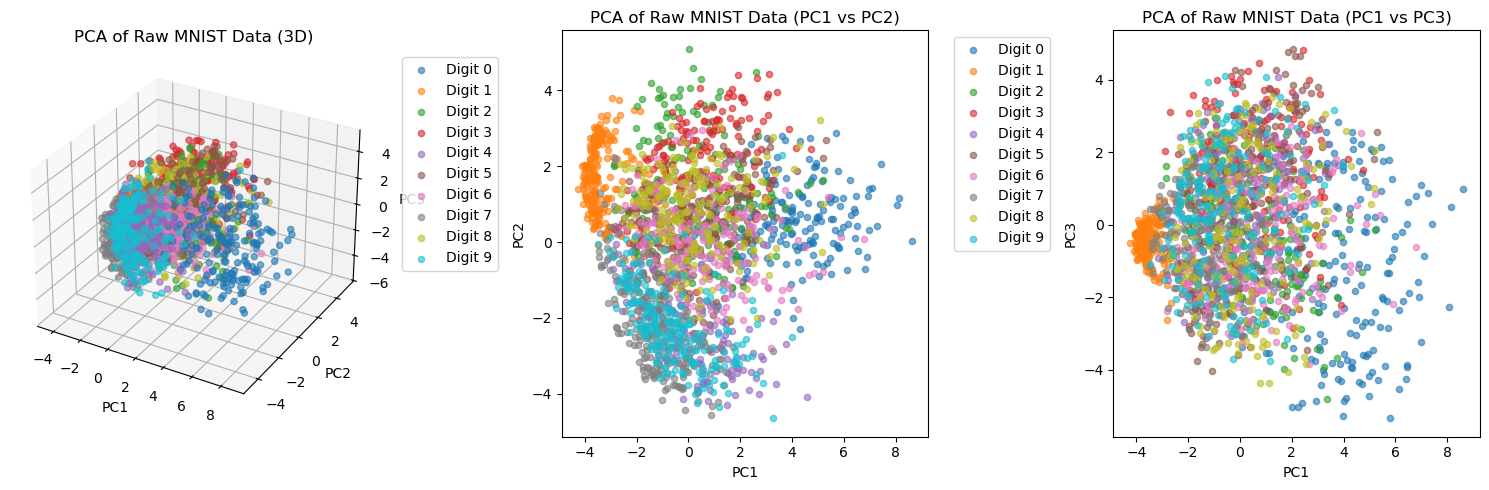

In [5]:
# 1. PCA on Raw MNIST Data
print("1. Performing PCA on raw MNIST data...")
pca_raw = PCA(n_components=3)
pca_features = pca_raw.fit_transform(vis_data)

print(f"Explained variance ratio: {pca_raw.explained_variance_ratio_}")
print(f"Total explained variance: {pca_raw.explained_variance_ratio_.sum():.3f}")

# Plot raw PCA
fig = plt.figure(figsize=(15, 5))

# 3D plot
ax1 = fig.add_subplot(131, projection='3d')
colors = plt.cm.tab10(np.linspace(0, 1, 10))
for i in range(10):
    mask = vis_labels == i
    ax1.scatter(pca_features[mask, 0], pca_features[mask, 1], pca_features[mask, 2], 
               c=[colors[i]], label=f'Digit {i}', alpha=0.6, s=20)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')
ax1.set_title('PCA of Raw MNIST Data (3D)')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 2D plots
ax2 = fig.add_subplot(132)
for i in range(10):
    mask = vis_labels == i
    ax2.scatter(pca_features[mask, 0], pca_features[mask, 1], 
               c=[colors[i]], label=f'Digit {i}', alpha=0.6, s=20)
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_title('PCA of Raw MNIST Data (PC1 vs PC2)')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax3 = fig.add_subplot(133)
for i in range(10):
    mask = vis_labels == i
    ax3.scatter(pca_features[mask, 0], pca_features[mask, 2], 
               c=[colors[i]], label=f'Digit {i}', alpha=0.6, s=20)
ax3.set_xlabel('PC1')
ax3.set_ylabel('PC3')
ax3.set_title('PCA of Raw MNIST Data (PC1 vs PC3)')

plt.tight_layout()
plt.show()


2. Training 3-layer dense network...
Epoch: 1, Batch: 0, Loss: 2.3064, Acc: 7.81%
Epoch: 1, Batch: 100, Loss: 0.3614, Acc: 77.86%
Epoch: 1, Batch: 200, Loss: 0.2517, Acc: 84.19%
Epoch: 1, Batch: 300, Loss: 0.2450, Acc: 87.06%
Epoch: 1, Batch: 400, Loss: 0.1245, Acc: 88.77%
Epoch 1 completed. Average Loss: 0.3558, Accuracy: 89.62%
Epoch: 2, Batch: 0, Loss: 0.0956, Acc: 99.22%
Epoch: 2, Batch: 100, Loss: 0.1109, Acc: 95.34%
Epoch: 2, Batch: 200, Loss: 0.1319, Acc: 95.43%
Epoch: 2, Batch: 300, Loss: 0.0855, Acc: 95.58%
Epoch: 2, Batch: 400, Loss: 0.0847, Acc: 95.66%
Epoch 2 completed. Average Loss: 0.1396, Accuracy: 95.75%
Epoch: 3, Batch: 0, Loss: 0.1055, Acc: 96.09%
Epoch: 3, Batch: 100, Loss: 0.0544, Acc: 96.91%
Epoch: 3, Batch: 200, Loss: 0.1563, Acc: 96.81%
Epoch: 3, Batch: 300, Loss: 0.0776, Acc: 96.90%
Epoch: 3, Batch: 400, Loss: 0.0889, Acc: 96.92%
Epoch 3 completed. Average Loss: 0.0983, Accuracy: 96.92%
Extracting features from dense network...
Dense network PCA explained varia

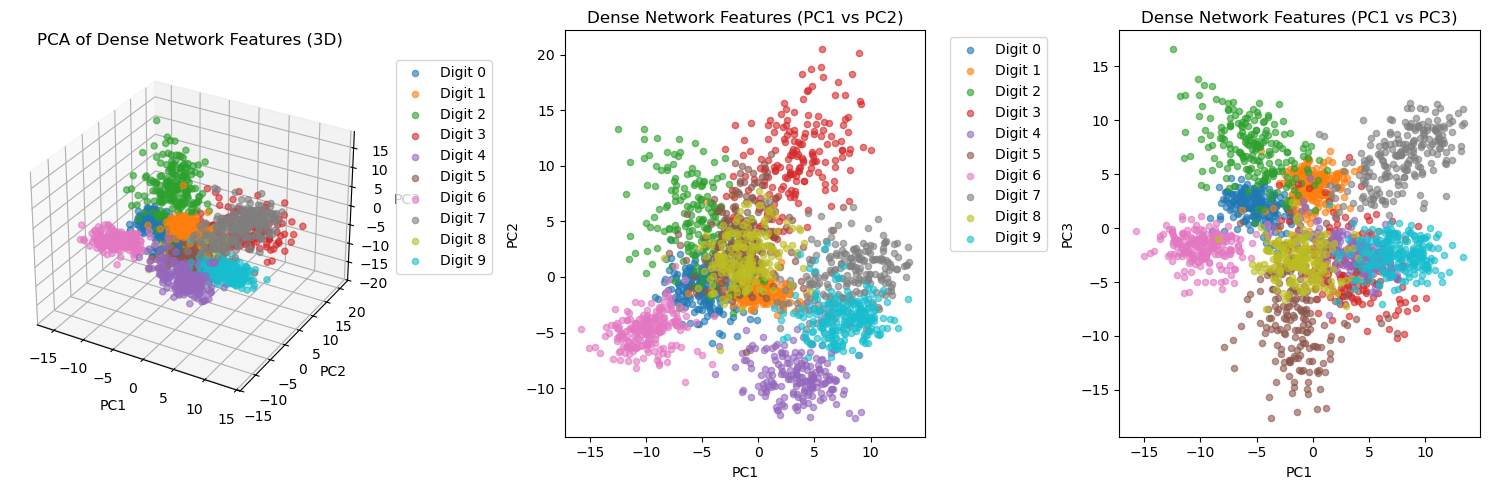

In [6]:
# 2. Dense Neural Network
print("\n2. Training 3-layer dense network...")

class DenseNet(nn.Module):
    def __init__(self, input_size=784, hidden_size=256, num_classes=10):
        super(DenseNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x, return_features=False):
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        features = x  # Features from last hidden layer
        x = self.dropout(x)
        x = self.fc3(x)
        
        if return_features:
            return x, features
        return x

# Initialize and train dense network
dense_net = DenseNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(dense_net.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
            
            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch+1}, Batch: {batch_idx}, '
                      f'Loss: {loss.item():.4f}, '
                      f'Acc: {100.*correct/total:.2f}%')
        
        print(f'Epoch {epoch+1} completed. '
              f'Average Loss: {running_loss/len(train_loader):.4f}, '
              f'Accuracy: {100.*correct/total:.2f}%')

# Train dense network
train_model(dense_net, train_loader, criterion, optimizer, epochs=3)

# Extract features from dense network
print("Extracting features from dense network...")
dense_net.eval()
dense_features = []
dense_labels = []

with torch.no_grad():
    # Use the same subset indices for consistency
    for i in range(0, len(vis_data), 100):  # Process in batches
        batch_data = vis_data[i:i+100]
        batch_labels = vis_labels[i:i+100]
        
        batch_tensor = torch.FloatTensor(batch_data.reshape(-1, 1, 28, 28)).to(device)
        _, features = dense_net(batch_tensor, return_features=True)
        
        dense_features.append(features.cpu().numpy())
        dense_labels.extend(batch_labels)

dense_features = np.vstack(dense_features)
dense_labels = np.array(dense_labels)

# PCA on dense network features
pca_dense = PCA(n_components=3)
pca_dense_features = pca_dense.fit_transform(dense_features)

print(f"Dense network PCA explained variance: {pca_dense.explained_variance_ratio_}")
print(f"Dense network total explained variance: {pca_dense.explained_variance_ratio_.sum():.3f}")

# Plot dense network PCA
fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(131, projection='3d')
for i in range(10):
    mask = dense_labels == i
    ax1.scatter(pca_dense_features[mask, 0], pca_dense_features[mask, 1], 
               pca_dense_features[mask, 2], c=[colors[i]], label=f'Digit {i}', 
               alpha=0.6, s=20)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')
ax1.set_title('PCA of Dense Network Features (3D)')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax2 = fig.add_subplot(132)
for i in range(10):
    mask = dense_labels == i
    ax2.scatter(pca_dense_features[mask, 0], pca_dense_features[mask, 1], 
               c=[colors[i]], label=f'Digit {i}', alpha=0.6, s=20)
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_title('Dense Network Features (PC1 vs PC2)')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax3 = fig.add_subplot(133)
for i in range(10):
    mask = dense_labels == i
    ax3.scatter(pca_dense_features[mask, 0], pca_dense_features[mask, 2], 
               c=[colors[i]], label=f'Digit {i}', alpha=0.6, s=20)
ax3.set_xlabel('PC1')
ax3.set_ylabel('PC3')
ax3.set_title('Dense Network Features (PC1 vs PC3)')

plt.tight_layout()
plt.show()


3. Training LeNet...
Epoch: 1, Batch: 0, Loss: 2.3003, Acc: 6.25%
Epoch: 1, Batch: 100, Loss: 0.3938, Acc: 70.58%
Epoch: 1, Batch: 200, Loss: 0.3366, Acc: 81.03%
Epoch: 1, Batch: 300, Loss: 0.1786, Acc: 85.40%
Epoch: 1, Batch: 400, Loss: 0.1093, Acc: 88.01%
Epoch 1 completed. Average Loss: 0.3640, Accuracy: 89.22%
Epoch: 2, Batch: 0, Loss: 0.2119, Acc: 93.75%
Epoch: 2, Batch: 100, Loss: 0.1586, Acc: 96.40%
Epoch: 2, Batch: 200, Loss: 0.1479, Acc: 96.75%
Epoch: 2, Batch: 300, Loss: 0.0419, Acc: 96.92%
Epoch: 2, Batch: 400, Loss: 0.0706, Acc: 97.09%
Epoch 2 completed. Average Loss: 0.0901, Accuracy: 97.17%
Epoch: 3, Batch: 0, Loss: 0.0995, Acc: 97.66%
Epoch: 3, Batch: 100, Loss: 0.0897, Acc: 97.87%
Epoch: 3, Batch: 200, Loss: 0.1156, Acc: 97.90%
Epoch: 3, Batch: 300, Loss: 0.0635, Acc: 97.88%
Epoch: 3, Batch: 400, Loss: 0.0983, Acc: 97.95%
Epoch 3 completed. Average Loss: 0.0646, Accuracy: 97.98%
Extracting features from LeNet...
LeNet PCA explained variance: [0.20636843 0.1843414  0.16

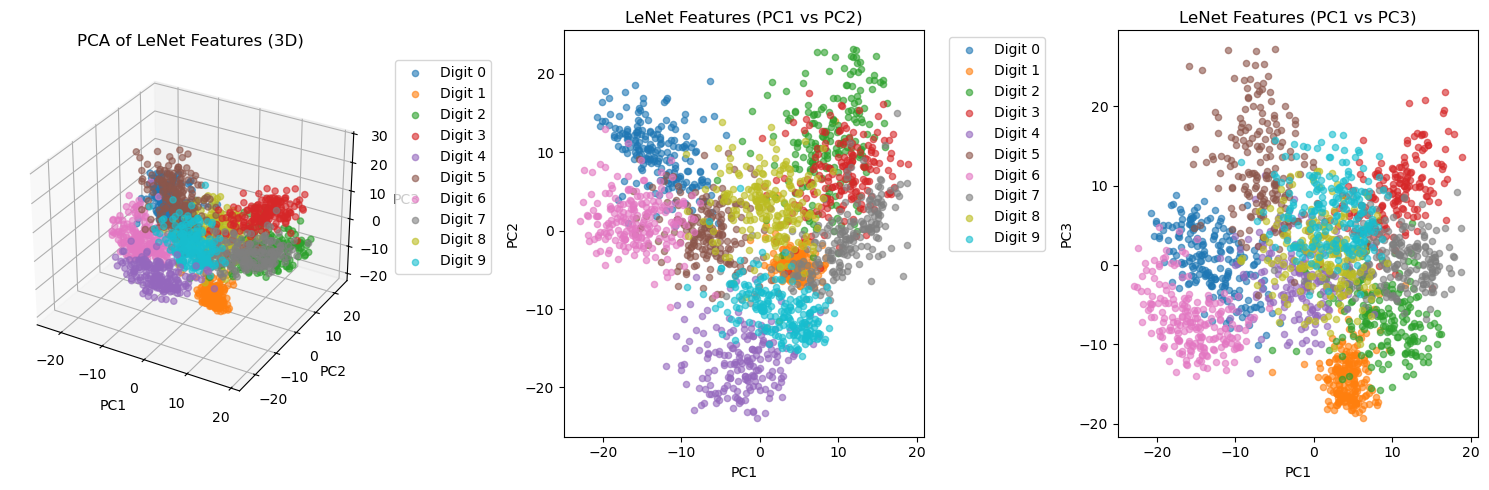

In [7]:
# 3. LeNet Convolutional Network
print("\n3. Training LeNet...")

class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5)
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, num_classes)
        
    def forward(self, x, return_features=False):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        
        # Features from last conv layer (before flattening)
        conv_features = x  # Shape: [batch, 120, 1, 1]
        
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        if return_features:
            return x, conv_features.view(conv_features.size(0), -1)  # Flatten conv features
        return x

# Initialize and train LeNet
lenet = LeNet().to(device)
lenet_optimizer = optim.Adam(lenet.parameters(), lr=0.001)

# Train LeNet
train_model(lenet, train_loader, criterion, lenet_optimizer, epochs=3)

# Extract features from LeNet
print("Extracting features from LeNet...")
lenet.eval()
lenet_features = []
lenet_labels = []

with torch.no_grad():
    # Use the same subset indices for consistency
    for i in range(0, len(vis_data), 100):
        batch_data = vis_data[i:i+100]
        batch_labels = vis_labels[i:i+100]
        
        batch_tensor = torch.FloatTensor(batch_data.reshape(-1, 1, 28, 28)).to(device)
        _, features = lenet(batch_tensor, return_features=True)
        
        lenet_features.append(features.cpu().numpy())
        lenet_labels.extend(batch_labels)

lenet_features = np.vstack(lenet_features)
lenet_labels = np.array(lenet_labels)

# PCA on LeNet features
pca_lenet = PCA(n_components=3)
pca_lenet_features = pca_lenet.fit_transform(lenet_features)

print(f"LeNet PCA explained variance: {pca_lenet.explained_variance_ratio_}")
print(f"LeNet total explained variance: {pca_lenet.explained_variance_ratio_.sum():.3f}")

# Plot LeNet PCA
fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(131, projection='3d')
for i in range(10):
    mask = lenet_labels == i
    ax1.scatter(pca_lenet_features[mask, 0], pca_lenet_features[mask, 1], 
               pca_lenet_features[mask, 2], c=[colors[i]], label=f'Digit {i}', 
               alpha=0.6, s=20)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')
ax1.set_title('PCA of LeNet Features (3D)')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax2 = fig.add_subplot(132)
for i in range(10):
    mask = lenet_labels == i
    ax2.scatter(pca_lenet_features[mask, 0], pca_lenet_features[mask, 1], 
               c=[colors[i]], label=f'Digit {i}', alpha=0.6, s=20)
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_title('LeNet Features (PC1 vs PC2)')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax3 = fig.add_subplot(133)
for i in range(10):
    mask = lenet_labels == i
    ax3.scatter(pca_lenet_features[mask, 0], pca_lenet_features[mask, 2], 
               c=[colors[i]], label=f'Digit {i}', alpha=0.6, s=20)
ax3.set_xlabel('PC1')
ax3.set_ylabel('PC3')
ax3.set_title('LeNet Features (PC1 vs PC3)')

plt.tight_layout()
plt.show()